# Tanzanian Water Pipe Predictions

# Overview

In this project, I was challenged to develop predictive models capable of determining the status of water pumps in Tanzania. There were three distinct classes that I needed to predict: functional, functional-needs-repair, and 
non-functional. By using an iterative process of adjusting features, sampling techniques, and hyper-parameters, I endeavored to find the most accurate predictive model.

# Data Understanding

I gained access to data from the Tanzanian Ministry of Water and a business named Taarifa. The data contained 59400 rows of data with 40 feature columns and 1 target column. There were both numeric and categorical columns in the data, and some of the apparently numeric columns also represented categorical information. Furthermore, several of the columns contained redundant information from other columns. In those cases, I choose the columns with more granular data that contained more useable details for my models to utilize in their construction. There were also several columns that required binning of values because the number of unique items within the column were voluminous, and would both provide superfluous specificity and also cost computational power. After I selected the feature columns I found to be most relevant for model construction, I began record data from baseline models. I also built iterative sklearn pipelines that allowed for quick and easy modification of my models' hyperparameters. 

In [161]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay, confusion_matrix, recall_score, \
    accuracy_score, precision_score, f1_score, plot_confusion_matrix, classification_report, log_loss

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
pd.set_option('display.max_columns', None)

Here is a brief look at the original feature data set. As you scroll from left to right, you can see that some columns are extraneous, some overlap but differ, and some are completely redundant. 

In [3]:
# Open the csv file, print its shape, and examine the first 5 rows of data
original_features_df = pd.read_csv('./Data/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
print(original_features_df.shape)
original_features_df.head()

(59400, 40)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


I then went through the process of indentifying the features I wanted to incorporate into my modeling, and verified that the information those columns contained was filled as accurately as possible. I replaced some values that were zeros, such as for "population", with np.nans so that they would be handled by my sklearn pipelines. I also binned many categorical values for columns like "subvillage" that contained thousands of distinct values. 

In [4]:
df = pd.read_csv('/Users/samalainabayeva/Desktop/Water Project CSVs/updated_features.csv', index_col=0)

In [5]:
print(df.shape)
df.head()

(59400, 27)


,amount_tsh,funder,gps_height,installer,basin,subvillage,region_code,district_code,lga,population,public_meeting,scheme_management,permit,construction_year,extraction_type,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,dates_passed,Target,ward,scheme_name
0,6000.0,Roman,1390,Roman,Lake Nyasa,Other,11,5,Ludewa,109.0,True,VWC,False,1999.0,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,995,0,other,Roman
1,NaN,other,1399,other,Lake Victoria,Other,20,2,Serengeti,280.0,NaN,Other,True,2010.0,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,272,0,Natta,NaN
2,25.0,other,686,dif_other,Pangani,Majengo,21,4,Simanjiro,250.0,True,VWC,True,2009.0,gravity,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,281,0,other,dif_other
3,NaN,other,263,dif_other,Ruvuma / Southern Coast,Other,90,63,Nanyumbu,58.0,True,VWC,True,1986.0,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,309,2,other,NaN
4,NaN,other,0,other,Lake Victoria,Other,18,1,Karagwe,NaN,True,NaN,True,NaN,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,874,0,other,NaN


After feature selection, my data now contained 26 feature columns, and 1 target column. The next steps that I needed to implement were the creation of a class to track the performance of my model iterations, to perform a train/test split on my data to prevent any form of data leakage, to create a smaller random sample of the data for me to use in grid searches in order to fine tune my hyper parameters, the composition of sklearn pipelines to facilitate easier revisions to my models per iteration, and the instantiation of a dummy model to provide a baseline standard of performance.

In [173]:
cross_validate(median_mm2, X_train, y_train, scoring=['precision_macro', 'accuracy', 'recall_macro', 'f1_macro'], n_jobs=4, verbose=1)
# for additional data on training set
# then use log loss on the test data, and find the same metrics, i.e. precision, accuracy, f1score

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   20.0s finished


{'fit_time': array([11.23073292, 11.14702535, 11.06779122, 11.03627586,  8.28846502]),
 'score_time': array([0.12961721, 0.12426281, 0.12158203, 0.12400317, 0.09755802]),
 'test_precision_macro': array([0.71166834, 0.70497284, 0.68231107, 0.69068176, 0.71198067]),
 'test_accuracy': array([0.76722783, 0.7637486 , 0.75645342, 0.76026936, 0.76554433]),
 'test_recall_macro': array([0.59835179, 0.59914638, 0.58558667, 0.58415602, 0.59122359]),
 'test_f1_macro': array([0.62130638, 0.62323954, 0.60639795, 0.6036509 , 0.61410944])}

In [174]:
np.mean(self.train_results['test_precision_macro'])
# add these columns to the dataframe
# add log_loss, just use cross_validation(scoring=)
# for test data use each function, assign predictions to an attribute, and use that attribute in the scoring functions

NameError: name 'self' is not defined

In [ ]:
np.mean(self.train_results['test_precision_macro'])
# add these columns to the dataframe
# add log_loss, just use 

In [ ]:
temp_df = pd.DataFrame(columns=)
# just provide the columns, 

## Preparation for model iteration

In [6]:
# Creating the class that will store my data

class Model():
    model_list = []
    model_df = pd.DataFrame({"Name": pd.Series(dtype='str'), "train_score": pd.Series(dtype='float64'),\
                             'train_log_loss': pd.Series(dtype='float64'), "test_score": pd.Series(dtype='float64'),
                             'test_log_loss': pd.Series(dtype='float64')})
    
    def __init__(self, name, model):
        self.name = name
        self.model = model
        self.params = model.get_params
        self.train_score = model.score(X_train, y_train)
        self.test_score = model.score(X_test, y_test)
        self.train_log_loss = -np.mean(cross_val_score(self.model, X_train, y_train, scoring='neg_log_loss'))
        self.test_log_loss = -np.mean(cross_val_score(self.model, X_test, y_test, scoring='neg_log_loss'))
        
        # need to access the elements from the dictionary as desired
        self.train_results = cross_validate(self.model, X_train, y_train, scoring='neg_log_loss')
        self.train_log_loss = self.train_results["train_"]
#         self.test_log_loss = -np.mean(cross_validate(self.model, X_test, y_test, scoring=['neg_log_loss'))
        
        self.test_log_loss = log_loss(y_test, self.model.predict(X_test))
                                        
        Model.model_list.append(self)
        attributes = np.array([self.name, self.train_score, self.train_log_loss, self.test_score, self.test_log_loss])
        self.attributes = attributes
        
        self.attributes_df = pd.DataFrame([attributes], columns=['Name', 'train_score', 'train_log_loss', \
                            'test_score', 'test_log_loss'])
        Model.model_df = pd.concat([Model.model_df, self.attributes_df], axis=0)

    @classmethod
    def get_model_list(cls):
        return cls.model_list

# I have to revise the construction of my class object in order to have better access to information and cleaner functionality

In [ ]:
cross_validate()

In [226]:
# Creating the class that will store my data

class Model_Info():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss'])
    
    def __init__(self, name, model, X_train, X_test, y_train, y_test):
        self.name = name
        self.model = model
        self.params = model.get_params
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Collection of training attributes
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision_macro', 'accuracy', 'recall_macro', 'f1_macro', 'neg_log_loss'], n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision_macro'])
        self.train_rec = np.mean(self.train_results['test_recall_macro'])
        self.train_f1 = np.mean(self.train_results['test_f1_macro'])
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)  # accuracy
        self.y_pred = self.model.predict(self.X_test)
        
        self.test_score = model.score(self.X_test, self.y_test)
        self.test_recall = recall_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        self.test_prec = precision_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        
        # Add model object to the class data container for access within the notebook
        Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss}
        
        # Add the metrics to the class dataframe
        Model_Info.model_df.loc[len(Model.model_df)] = self.attributes
    
    def __repr__(self):
      return f"Model name: ({self.model})"
    
    
    @classmethod
    def get_model_list(cls):
        return cls.model_list

In [203]:
recall_score(y_test, median_mm2.predict(X_test), average='macro')

0.5921759352638454

In [206]:
median_mima2 = Model_Info("median_fill_minmax", median_mm2, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   15.6s finished


In [207]:
Model_Info.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss


In [180]:
log_loss(y_test, median_mm2.predict_proba(X_test))
median_mm2.score()

0.5707655340857761

In [191]:
cross_validate(median_mm2, X_train, y_train, scoring=['precision_macro', 'accuracy', 'recall_macro', 'f1_macro', 'neg_log_loss'], n_jobs=4, verbose=1)
# for additional data on training set
# then use log loss on the test data, and find the same metrics, i.e. precision, accuracy, f1score

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   15.8s finished


{'fit_time': array([8.2587471 , 8.14288211, 8.1620841 , 8.18794489, 7.09730887]),
 'score_time': array([0.17536998, 0.17622614, 0.17546201, 0.17505217, 0.16904092]),
 'test_precision_macro': array([0.71166834, 0.70497284, 0.68231107, 0.69068176, 0.71198067]),
 'test_accuracy': array([0.76722783, 0.7637486 , 0.75645342, 0.76026936, 0.76554433]),
 'test_recall_macro': array([0.59835179, 0.59914638, 0.58558667, 0.58415602, 0.59122359]),
 'test_f1_macro': array([0.62130638, 0.62323954, 0.60639795, 0.6036509 , 0.61410944]),
 'test_neg_log_loss': array([-0.5652598 , -0.57738118, -0.58112682, -0.57916981, -0.58392637])}

In [176]:
test_loss = log_loss(y_test, model.predict_proba(X_test))
# investigate for multi-class compatability

NameError: name 'model' is not defined

- cross_validate to replace cross_val_score, with specific metrics
- testing data, assign y_pred value to an attribute, y_predict_proba for log_loss - play around with predict proba indexes
- correct dataframe instantiation, and tailor self.attributes to be a dictionary, then append
- add parameters to init method for X_train etc. 
- cross validate returns a dictionary, so remember to take the mean value of the k-number folds returned

In [7]:
# Create the smaller data set to be used in grid searches
sample_data = df.sample(5000, random_state=42)

In [8]:
# Train/test split on the data
X = df.drop("Target", axis = 1)
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
# Create Pipelines for numeric and categorical data

subpipe_numerics = Pipeline(steps=[
    ('mean_impute', SimpleImputer(add_indicator=True, strategy='mean')),
    ('ss', StandardScaler())
], verbose=True)

sub_pipe_cat = Pipeline(steps=[
    
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=True))  
], verbose=True)

In [10]:
# Create a column transformer to implement the above sub-pipelines

CT = ColumnTransformer(transformers=[
    ('subpipe_numerics', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', sub_pipe_cat, selector(dtype_include=object))
], remainder='passthrough', n_jobs= 4, verbose=True)

In [11]:
# Create the final pipeline for model instantiation.
dummy_model = Pipeline(steps=[
    ('CT', CT),
    ('dummy', DummyClassifier(strategy="most_frequent"))
], verbose=True)

Now that all of the basic components are in place, I tested the results of the DummyClassifier model in order to establish a performance baseline.

## Dummy model instantiation

In [12]:
dummy_model.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing CT, total=  10.2s
[Pipeline] ............. (step 2 of 2) Processing dummy, total=   0.0s


Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8b56eb5730>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                   

I then examined the performance of this dummy model, and instantiated it as a new class object. 

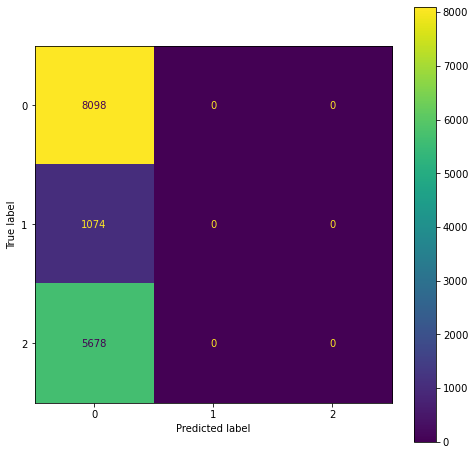

In [13]:
# Plotting a confusion matrix; all of the predictions were for class 0 - the most frequently occurring class
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(dummy_model, X_test, y_test, ax=ax);

In [14]:
# Looking at the classification report to assess the performance metrics of the dummy on test data
print(classification_report(y_test, dummy_model.predict(X_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      8098
           1       0.00      0.00      0.00      1074
           2       0.00      0.00      0.00      5678

    accuracy                           0.55     14850
   macro avg       0.18      0.33      0.24     14850
weighted avg       0.30      0.55      0.38     14850



In [15]:
# Substantiating the results of the classification report by examing the value counts of the target in test data
y_test.value_counts(normalize=True)

0    0.545320
2    0.382357
1    0.072323
Name: Target, dtype: float64

In [16]:
dummy_baseline = Model("dummy", dummy_model)

[Pipeline] ................ (step 1 of 2) Processing CT, total=   6.8s
[Pipeline] ............. (step 2 of 2) Processing dummy, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   5.9s
[Pipeline] ............. (step 2 of 2) Processing dummy, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   5.8s
[Pipeline] ............. (step 2 of 2) Processing dummy, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   5.8s
[Pipeline] ............. (step 2 of 2) Processing dummy, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   5.9s
[Pipeline] ............. (step 2 of 2) Processing dummy, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s
[Pipeline] ............. (step 2 of 2) Processing dummy, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s
[Pipeline] ............. (step 2 of 2) Processing dummy, total=   0.0s
[Pipel

In [17]:
# First examination of the model df to capture performance statistics
Model.model_df

,Name,train_score,train_log_loss,test_score,test_log_loss
0,dummy,0.542334455667789,15.807207899345318,0.5453198653198653,15.704095502925046


Now that I had tested a dummy model, I was prepared to test logistic regression models. Within my iteration notebook, I would simply have scrolled up and modified the components of various pipelines, but for the sake of this notebook, I will show the first implementation of a Logistic Regression model below. This model will still take advantage of the sub-pipes and column transformer that I had constructed above, and therefore the only new code cell will be the final Pipeline object used in the creation of this new model.

## Baseline Logistic Regression Model

In [18]:
# I have limited the njobs=4 only because my computer had performance barriers during this project

baseline_logistic = Pipeline(steps=[
    ('CT', CT),
    ('baseline_log', LogisticRegression(verbose=1, n_jobs=4))
], verbose=True)

In [19]:
# Fitting the baseline model to training data
baseline_logistic.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing CT, total=   9.4s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.6s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   2.7s


Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8b56eb5730>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                   

Now that the baseline logistic regression model was fit, I examined the confusion matrix and classification report as I did with the baseline dummy model to assess whether there had been any improvement in the classification ability of the model.

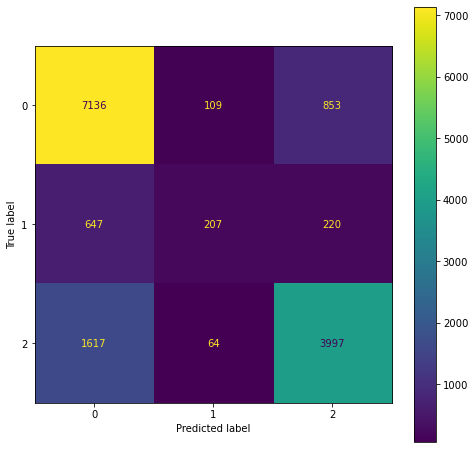

In [20]:
# Plotting a confusion matrix; using the test data
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(baseline_logistic, X_test, y_test, ax=ax);

In [21]:
# Looking at the classification report on test data
print(classification_report(y_test, baseline_logistic.predict(X_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      8098
           1       0.54      0.19      0.28      1074
           2       0.79      0.70      0.74      5678

    accuracy                           0.76     14850
   macro avg       0.70      0.59      0.61     14850
weighted avg       0.75      0.76      0.75     14850



In [22]:
# Creating a new class object for the purpose of tracking data
logistic_baseline = Model("logistic_1", baseline_logistic)

[Pipeline] ................ (step 1 of 2) Processing CT, total=   6.0s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.1s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   2.2s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   6.1s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.0s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   2.1s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   5.9s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.1s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   2.2s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   5.9s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.1s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   2.2s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   6.0s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.9s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   2.0s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.7s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   0.8s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.8s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   0.9s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.8s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   0.9s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.8s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   0.9s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   0.9s


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.8s finished


In [23]:
# Checking the updated dataframe to compare the first two models
Model.model_df

,Name,train_score,train_log_loss,test_score,test_log_loss
0,dummy,0.542334455667789,15.807207899345318,0.5453198653198653,15.704095502925046
0,logistic_1,0.7717620650953985,0.5773054993346605,0.7636363636363637,0.5987052306678315


The first incarnation of a logistic regression model already made substantial improvements on the results of the dummy model. The test score had improved by nearly 22 basis points and the mean log loss had dropped precipitously from around 15.7 to less than 0.6. These metric improvements were quite significant, and gave hope that further improvements might be made.

## Grid Searches

The next effort to improve upon this model was conducting a grid search in order to tune the hyper-parameters of the logistic regression model. The default hyper-parameters I wanted to manipulate for an sklearn LogisticRegression model object are:
- penalty = 'l2' ('l1' and 'l2' were my primary focus)
- tol = 0.0001
- C = 1.0
- fit_intercept = True
- solver = 'lbfgs' (only 'newton-cg', 'sag', 'saga', and 'lbfgs' are suited for multinomial loss)
- max_iter = 100

Once again, because of computational limitations, I had to perform the grid search using a smaller sample of the overall data.

In [24]:
# Investigating the hyper-parameters that I want to search for, loop optional, but improves readability 
for i in baseline_logistic.get_params().keys():
    print(i)

memory
steps
verbose
CT
baseline_log
CT__n_jobs
CT__remainder
CT__sparse_threshold
CT__transformer_weights
CT__transformers
CT__verbose
CT__subpipe_numerics
CT__subpipe_cat
CT__subpipe_numerics__memory
CT__subpipe_numerics__steps
CT__subpipe_numerics__verbose
CT__subpipe_numerics__mean_impute
CT__subpipe_numerics__ss
CT__subpipe_numerics__mean_impute__add_indicator
CT__subpipe_numerics__mean_impute__copy
CT__subpipe_numerics__mean_impute__fill_value
CT__subpipe_numerics__mean_impute__missing_values
CT__subpipe_numerics__mean_impute__strategy
CT__subpipe_numerics__mean_impute__verbose
CT__subpipe_numerics__ss__copy
CT__subpipe_numerics__ss__with_mean
CT__subpipe_numerics__ss__with_std
CT__subpipe_cat__memory
CT__subpipe_cat__steps
CT__subpipe_cat__verbose
CT__subpipe_cat__cat_impute
CT__subpipe_cat__ohe
CT__subpipe_cat__cat_impute__add_indicator
CT__subpipe_cat__cat_impute__copy
CT__subpipe_cat__cat_impute__fill_value
CT__subpipe_cat__cat_impute__missing_values
CT__subpipe_cat__cat_impu

In [25]:
# Establishing a starting dictionary of parameters and optional values
parameters = {
    "baseline_log__penalty": ["l1", "l2"],
    "baseline_log__tol": [.0001, .001, .01],
    "baseline_log__C": [1, .1, .01],
    "baseline_log__fit_intercept": [True, False],
    "baseline_log__solver": ['newton-cg', 'sag', 'lbfgs'],
    "baseline_log__max_iter": [100, 250, 500]
}

In [26]:
grid_search = GridSearchCV(
    estimator=baseline_logistic,
    param_grid=parameters,
    n_jobs=4,
    cv=5,
    verbose=2)

In [27]:
# Assigning variables of the sample data for grid search
X_sample = sample_data.drop('Target', axis=1)
y_sample = sample_data['Target']

With the grid search parameters and GridSearchCV object defined, the next step is to fit my sample data using the GridSearchCV object. Grid search will perform 5 folds for 2 penalties, 3 tolerances, 3 C values, 2 intercept conditions, 3 solvers, and 3 max_iter values.

In [28]:
5*2*3*3*2*3*3

1620

That means that the grid search will fit perform 1620 separate fits. Given that my original data's train set is roughly 50k values, this 5k sample is a much more manageable computational load.

In [29]:
# Cell takes approximately 3 minutes to run
grid_search.fit(X_sample, y_sample)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   28.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 1620 out of 1620 | elapsed:  3.8min finished


[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.3s


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 0 seconds
[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   0.6s


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(n_jobs=4,
                                                          remainder='passthrough',
                                                          transformers=[('subpipe_numerics',
                                                                         Pipeline(steps=[('mean_impute',
                                                                                          SimpleImputer(add_indicator=True)),
                                                                                         ('ss',
                                                                                          StandardScaler())],
                                                                                  verbose=True),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f8b56eb5730>)

After the completion of the grid search, I would investigate different components of the model. The attribute 'best_params_' displays the hyper-parameters for the model with the best score, whereas 'best_estimator_' is the actual model object using the best hyper-parameters.

In [30]:
grid_search.best_params_

{'baseline_log__C': 1,
 'baseline_log__fit_intercept': False,
 'baseline_log__max_iter': 100,
 'baseline_log__penalty': 'l2',
 'baseline_log__solver': 'sag',
 'baseline_log__tol': 0.0001}

In [31]:
# Displays the characteristics of the best model as determined by the grid search
grid_search.best_estimator_

Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8b3b749f10>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                   

In [32]:
# Displays the best score from the grid search
grid_search.best_score_

0.7535999999999999

You will note that the best score for the grid search is not as high as the initial score for the train/test split data. That could be due to the random 5k sample that was taken, but the relative lack of improvement after conducting a 1620 fit grid search is moderately disconcerting. Furthermore, the best params found by the grid search were:
- C = 1
- fit_intercept = True
- max_iter = 100
- penalty = 'l2'
- solver = 'sag'
- tol = 0.0001

So the only modification to the default values of the LogisticRegression object was the solver. After finding these best params, I fit the X_train and y_train full sized sets to the model with those hyperparameters, investigated their metrics, and instantiated an object to track its data.

In [33]:
# Assigning the best-params model to a variable and fitting the data
grid_baseline_log = grid_search.best_estimator_
grid_baseline_log.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing CT, total=  10.0s


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 6 seconds
[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   5.3s


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    5.3s finished


Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8b3b749f10>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                   

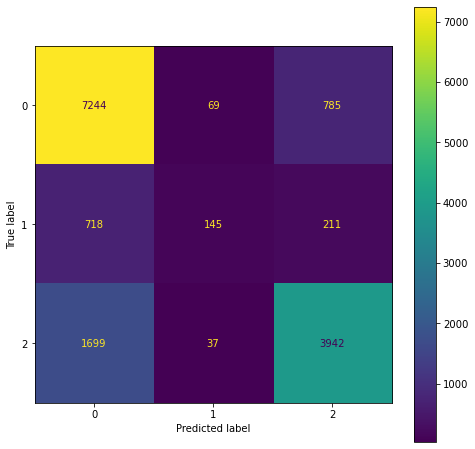

In [34]:
# Plotting a confusion matrix; using the test data after fitting grid search best estimator
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(grid_baseline_log, X_test, y_test, ax=ax);

In [35]:
# Looking at the classification report on test data after fitting grid search best estimator
print(classification_report(y_test, grid_baseline_log.predict(X_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.75      0.89      0.82      8098
           1       0.58      0.14      0.22      1074
           2       0.80      0.69      0.74      5678

    accuracy                           0.76     14850
   macro avg       0.71      0.57      0.59     14850
weighted avg       0.76      0.76      0.74     14850



In [36]:
# Creating a new class object for the purpose of tracking data
grid_logistic_baseline = Model("grid_logistic_1", grid_baseline_log)

[Pipeline] ................ (step 1 of 2) Processing CT, total=   6.5s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    4.2s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   4.3s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   6.2s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.9s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   4.0s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   5.9s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    4.0s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   4.1s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   5.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.9s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   4.0s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   5.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.8s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   3.9s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.2s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   1.3s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.1s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   1.2s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.2s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   1.3s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.2s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   1.3s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   1.3s


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.2s finished


In [37]:
# Checking the updated dataframe to compare the first three models
Model.model_df

,Name,train_score,train_log_loss,test_score,test_log_loss
0,dummy,0.542334455667789,15.807207899345318,0.5453198653198653,15.704095502925046
0,logistic_1,0.7717620650953985,0.5773054993346605,0.7636363636363637,0.5987052306678315
0,grid_logistic_1,0.7669809203142537,0.5860820811902359,0.7630303030303031,0.5960105794752986


So, somewhat discouragingly, the grid-searched best parameters have led to a reduction in performance from the original vanilla logistic regression model. As a reminder, the only hyper-parameter that was altered was the solver, from 'lbfgs' to 'sag'. In one regard, that is positive, as we can definitively say that the 'sag' solver performs worse than the 'lbfgs' solver given these hyper-parameters, on the other hand, the model moved in the wrong direction.

## SMOTE - synthetic up-sampling

One final tool that I employed is using SMOTE to synthetically increase the representation of minority classes within the data. This process utilizes nearly identical pipelines for preparing data for modeling, however the specific pipeline object comes from the imblearn library, not sklearn.

In [38]:
smote_pipeline = ImPipeline(steps=[
    ("CT", CT),
    ("smote", SMOTE(n_jobs= 4, sampling_strategy='auto')),  
    # auto is both default and equivalent to 'not_majority'
    
    ('baseline_log', LogisticRegression(verbose=1, n_jobs=4)), 
    # using the same hyper-parameters as baseline/best model
], verbose= True)

In [39]:
# Fitting the training data while synthetically up-sampling minority classes
smote_pipeline.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 3) Processing CT, total=   8.7s
[Pipeline] ............. (step 2 of 3) Processing smote, total=  27.6s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.9s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   4.0s


Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8b56eb5730>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                   

After fitting the smote pipeline to my training data, I looked at the same visualization and report, and then subsequently added the new model to my class data frame as well.

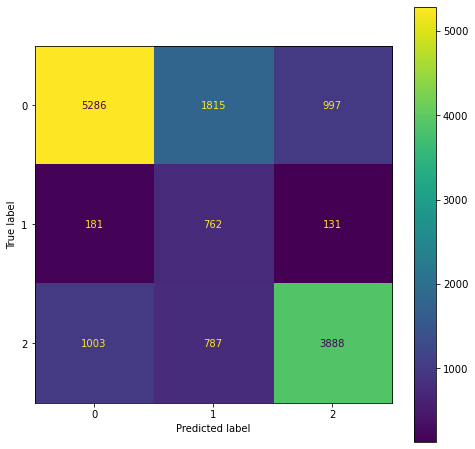

In [40]:
# Plotting a confusion matrix; using the test data
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(smote_pipeline, X_test, y_test, ax=ax);

In [41]:
# Looking at the classification report on test data
print(classification_report(y_test, smote_pipeline.predict(X_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.82      0.65      0.73      8098
           1       0.23      0.71      0.34      1074
           2       0.78      0.68      0.73      5678

    accuracy                           0.67     14850
   macro avg       0.61      0.68      0.60     14850
weighted avg       0.76      0.67      0.70     14850



In [42]:
# Creating a new class object for the purpose of tracking data
smote_baseline = Model("smote_1", smote_pipeline)

[Pipeline] ................ (step 1 of 3) Processing CT, total=   5.9s
[Pipeline] ............. (step 2 of 3) Processing smote, total=  16.9s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.3s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   3.4s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   5.9s
[Pipeline] ............. (step 2 of 3) Processing smote, total=  17.1s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.4s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   3.5s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   6.0s
[Pipeline] ............. (step 2 of 3) Processing smote, total=  17.3s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.2s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   3.3s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   5.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=  16.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.2s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   3.3s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   5.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=  16.5s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.2s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   3.3s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   1.9s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.1s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   1.2s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   1.9s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.2s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   1.3s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   1.9s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.1s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   1.3s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   1.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.2s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   1.3s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   1.8s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   1.3s


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.2s finished


In [43]:
Model.model_df

,Name,train_score,train_log_loss,test_score,test_log_loss
0,dummy,0.542334455667789,15.807207899345318,0.5453198653198653,15.704095502925046
0,logistic_1,0.7717620650953985,0.5773054993346605,0.7636363636363637,0.5987052306678315
0,grid_logistic_1,0.7669809203142537,0.5860820811902359,0.7630303030303031,0.5960105794752986
0,smote_1,0.683658810325477,0.7208385718554025,0.6690909090909091,0.7335804610517396


In [90]:
# Checking the updated dataframe to compare the first two models
Model.model_df

,Name,train_score,train_log_loss,test_score,test_log_loss
0,dummy,0.542334455667789,15.807207899345318,0.5453198653198653,15.704095502925046
0,logistic_1,0.7717620650953985,0.5773054993346605,0.7636363636363637,0.5987052306678315
0,grid_logistic_1,0.7671380471380471,0.5860681265161783,0.762962962962963,0.5960136139451608
0,smote_1,0.6814814814814815,0.7214257060683422,0.6671380471380471,0.7353518743976217


This was a somewhat startling iteration of the model. As you can see, the test score got materially worse using the SMOTE synthetic up-sampling of minority data. Log loss also got worse. 

## Preliminary comparison of the first models' performance

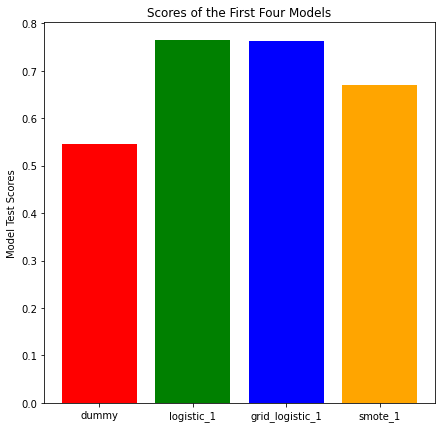

In [44]:
# Plotting the scores of the first four models on test data

visual = Model.model_df
scores = visual['test_score'].astype(float)

fig, ax = plt.subplots(figsize=(7,7))
colors = ['red', 'green', 'blue', 'orange']
ax.bar(x=range(4), height=scores, color=colors)
ax.set_xticks(range(len(visual['Name'])))
ax.set_xticklabels(visual["Name"])
ax.set_title("Scores of the First Four Models")
ax.set_ylabel("Model Test Scores");

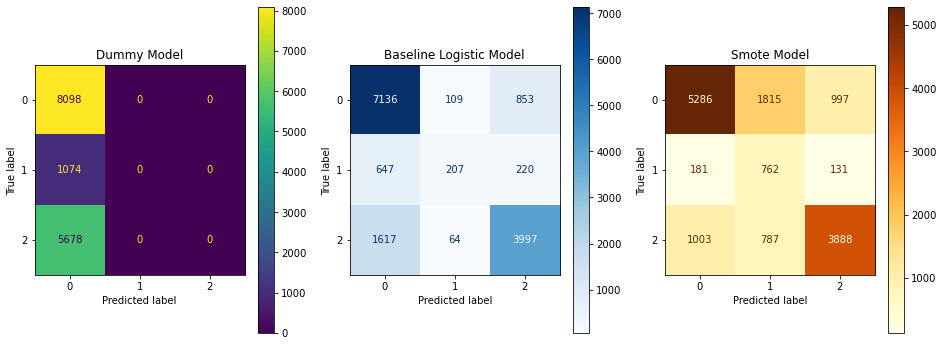

In [45]:
# Plotting the confusion matrices of the dummy, baseline/best, and smote models

fig, ax = plt.subplots(ncols = 3, figsize=(16,6))

plot_confusion_matrix(dummy_model, X_test, y_test, ax=ax[0])
ax[0].set_title("Dummy Model")
plot_confusion_matrix(baseline_logistic, X_test, y_test, ax=ax[1], cmap='Blues')
ax[1].set_title("Baseline Logistic Model")
plot_confusion_matrix(smote_pipeline, X_test, y_test, ax=ax[2], cmap="YlOrBr")
ax[2].set_title("Smote Model");

Looking at the colormaps, it is clear to see that by synthetically up-sampling the minority classes, that class 1, "functional-needs-repair" ended up being predicted at a too-high frequency. That being said, there is still close agreement between the baseline model and the smote model on predicting class 2 - "non-functional".

This process was repeated many times, with the continued manipulation of hyper-parameters in order to improve upon model performance. I have omitted many iterations for the purpose of keeping this notebook as concise as possible, however the above processes adequately describe how each iteration was created and modified.

# Conclusion

# Pipeline

In [46]:
# Create Pipelines for numeric and categorical data

subpipe_numerics = Pipeline(steps=[
    ('mean_impute', SimpleImputer(add_indicator=True, strategy='mean')),
    ('ss', StandardScaler())
], verbose=True)

sub_pipe_cat = Pipeline(steps=[
    
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=True))  
], verbose=True)

In [47]:
# Create a column transformer to implement the above sub-pipelines

CT = ColumnTransformer(transformers=[
    ('subpipe_numerics', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', sub_pipe_cat, selector(dtype_include=object))
], remainder='passthrough', n_jobs= 4, verbose=True)

In [48]:
# Create the final pipeline for model instantiation.
dummy_model = Pipeline(steps=[
    ('CT', CT),
    ('dummy', DummyClassifier(strategy="most_frequent"))
], verbose=True)

# Grid

In [49]:
# Establishing a starting dictionary of parameters and optional values
parameters = {
    "baseline_log__penalty": ["l1", "l2"],
    "baseline_log__tol": [.0001, .001, .01],
    "baseline_log__C": [1, .1, .01],
    "baseline_log__fit_intercept": [True, False],
    "baseline_log__solver": ['newton-cg', 'sag', 'lbfgs'],
    "baseline_log__max_iter": [100, 250, 500]
}

In [50]:
grid_search = GridSearchCV(
    estimator=baseline_logistic,
    param_grid=parameters,
    n_jobs=4,
    cv=5,
    verbose=2)

# Smote

In [57]:
smote_2 = ImPipeline(steps=[
    ("CT", CT),
    ("smote", SMOTE(n_jobs= 4, sampling_strategy='not majority')),  
    # auto is both default and equivalent to 'not_majority'
    
    ('baseline_log', LogisticRegression(verbose=1, n_jobs=4, C=.01, max_iter=200, 
                                        multi_class='multinomial', solver='newton-cg', tol=1)), 
    # using the same hyper-parameters as baseline/best model
], verbose= True)

In [ ]:
'sm',
                 SMOTE(random_state=42, sampling_strategy='not majority')),
                ('smote_trial',
                 LogisticRegression(C=0.01, fit_intercept=False, max_iter=200,
                                    multi_class='multinomial', n_jobs=-1,
                                    solver='newton-cg', tol=1))])

In [58]:
# Fitting the training data while synthetically up-sampling minority classes
smote_2.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 3) Processing CT, total=  10.1s
[Pipeline] ............. (step 2 of 3) Processing smote, total=  26.6s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    6.4s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   6.5s


Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8a4afc5cd0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImput...
                                                      

In [59]:
smote_2 = Model("c.01_mi200_svr_ncg_tol_1", smote_2)

[Pipeline] ................ (step 1 of 3) Processing CT, total=   6.0s
[Pipeline] ............. (step 2 of 3) Processing smote, total=  16.7s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    4.7s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   4.8s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   5.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=  16.9s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    5.1s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   5.2s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   5.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=  17.0s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    4.6s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   4.7s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   5.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=  16.9s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    4.7s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   4.8s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   6.0s
[Pipeline] ............. (step 2 of 3) Processing smote, total=  17.7s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    4.6s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   4.7s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   2.0s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.0s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   1.1s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   2.0s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.3s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   1.4s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   2.1s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   1.6s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   0.9s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   2.0s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.1s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   1.2s
[Pipeline] ................ (step 1 of 3) Processing CT, total=   0.8s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   2.0s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   1.2s


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.1s finished


In [60]:
Model.model_df

,Name,train_score,train_log_loss,test_score,test_log_loss
0,dummy,0.542334455667789,15.807207899345318,0.5453198653198653,15.704095502925046
0,logistic_1,0.7717620650953985,0.5773054993346605,0.7636363636363637,0.5987052306678315
0,grid_logistic_1,0.7669809203142537,0.5860820811902359,0.7630303030303031,0.5960105794752986
0,smote_1,0.683658810325477,0.7208385718554025,0.6690909090909091,0.7335804610517396
0,lr_C.01_mi200_solv_n.cg,0.7533782267115601,0.6144197210579996,0.750976430976431,0.6425524499944191
0,c.01_mi200_svr_ncg_tol_1,0.6776206509539843,0.7479233762134583,0.6682154882154883,0.7735719855890466


# Model tweaks

In [142]:
X_train.isna().sum()

amount_tsh           31274
funder                2691
gps_height               0
installer             2700
basin                    0
subvillage             282
region_code              0
district_code            0
lga                      0
population           15972
public_meeting        2525
scheme_management     2922
permit                2285
construction_year    15463
extraction_type          0
management               0
management_group         0
payment_type             0
water_quality            0
quantity                 0
source                   0
source_class             0
waterpoint_type          0
dates_passed             0
ward                     0
scheme_name          21132
dtype: int64

In [153]:
# Create Pipelines for numeric and categorical data

subpipe_numerics = Pipeline(steps=[
    ('mean_impute', SimpleImputer(strategy='median', add_indicator=True, verbose=1)),
    ('m_m_s', MinMaxScaler()),
], verbose=True)

sub_pipe_cat = Pipeline(steps=[
    
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True, verbose=1)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=True))  
], verbose=True)

In [154]:
# Create a column transformer to implement the above sub-pipelines

CT = ColumnTransformer(transformers=[
    ('subpipe_numerics', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', sub_pipe_cat, selector(dtype_include=object))
], remainder='passthrough', n_jobs= 4, verbose=True)

### Blast through these iterations

In [216]:
dummy = Pipeline(steps=[
    ('CT', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
], verbose=True)

# This is where I utilize my new class, and create the dataframe 

In [217]:
dummy.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing CT, total=   9.5s
[Pipeline] ............. (step 2 of 2) Processing dummy, total=   0.0s


Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median',
                                                                                 verbose=1)),
                                                                  ('m_m_s',
                                                                   MinMaxScaler())],
                                                           verbose=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8a4d611be0>),
                                                 ('subpipe_cat',
                        

In [227]:
dummy_model = Model_Info("dummy_classifier", dummy, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   12.0s finished


In [228]:
Model_Info.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss
20,dummy_classifier,0.542334,0.180778,0.333333,0.234421,15.807208,0.54532,0.181773,0.333333,0.235257,15.704096


## Only numbers 

In [107]:
X_train_numeric = X_train.select_dtypes(include=np.number)
X_test_numeric = X_test.select_dtypes(include=np.number)

In [120]:
# X_train.select_dtypes(include="object").head(2)

In [119]:
# X_train['scheme_management'].value_counts()

In [122]:
# Columns to be dropped:
drop_cols = ['ward', 'scheme_name', 'payment_type']

In [156]:
median_mm2.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing CT, total=   9.8s
[Pipeline] ........... (step 2 of 2) Processing logreg2, total=   3.0s


Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median',
                                                                                 verbose=1)),
                                                                  ('m_m_s',
                                                                   MinMaxScaler())],
                                                           verbose=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8a4d611be0>),
                                                 ('subpipe_cat',
                        

In [157]:
median_minmax2 = Model("median_fill_2, min_max", median_mm2)

[Pipeline] ................ (step 1 of 2) Processing CT, total=   6.1s
[Pipeline] ........... (step 2 of 2) Processing logreg2, total=   2.1s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   6.2s
[Pipeline] ........... (step 2 of 2) Processing logreg2, total=   2.2s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   6.0s
[Pipeline] ........... (step 2 of 2) Processing logreg2, total=   2.0s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   6.0s
[Pipeline] ........... (step 2 of 2) Processing logreg2, total=   2.2s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   6.1s
[Pipeline] ........... (step 2 of 2) Processing logreg2, total=   2.1s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s
[Pipeline] ........... (step 2 of 2) Processing logreg2, total=   0.9s
[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.8s
[Pipeline] ........... (step 2 of 2) Processing logreg2, total=   0.8s
[Pipel

In [229]:
Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Water Project CSVs/2nd_add_table.csv')

In [209]:
dummy_model

Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8a4afc5cd0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                   

In [223]:
dummy_model = Model_Info("dummy_classifier", Model.model_list[0], X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

AttributeError: 'Model' object has no attribute 'get_params'

In [213]:
dummyddd = Model.model_list[0]

In [ ]:
dummyddd.get_m

In [ ]:
Model_Info.model_df

# Observations:
- Changing sampling strategy to "auto" made no difference in SMOTE hyperparameters.
- Baseline log grid slightly worse than the uncalibrated logistic regression
- For polynomial features, the grid search did not improve the default settings at all, still not overfit
- After a 2 hour grid search, the best model only equals the best score thus far, still without overfitting, but without any improvement either.
- Polynomial degree 2 + smote improved upon the baseline smote, but still performed worse than other models

- Adding the dates_passed column improved the model very slightly. I will now re-check cleaning/feature selection.
#### Returning to the baseline logistic regression model and modifying from there
- Baseline Logistic Regression continues to be the best model
- StandardScaler and MinMaxScaler produced the same exact results
- Median fill and mean fill produced identical results

In [147]:
X_train.isna().sum()

amount_tsh           31274
funder                2691
gps_height               0
installer             2700
basin                    0
subvillage             282
region_code              0
district_code            0
lga                      0
population           15972
public_meeting        2525
scheme_management     2922
permit                2285
construction_year    15463
extraction_type          0
management               0
management_group         0
payment_type             0
water_quality            0
quantity                 0
source                   0
source_class             0
waterpoint_type          0
dates_passed             0
ward                     0
scheme_name          21132
dtype: int64

In [152]:
# X_train.sort_values(by=X_train.dtypes).info()

In [146]:
type(X_train['permit'][0])

bool

In [141]:
X_train.mean()

amount_tsh           1095.163276
gps_height            668.105926
region_code            15.366846
district_code           5.651291
population            278.719400
public_meeting          0.908507
permit                  0.687992
construction_year    1996.833224
dates_passed          613.439304
dtype: float64

In [140]:
X_train.median()

amount_tsh            250.0
gps_height            369.0
region_code            12.0
district_code           3.0
population            150.0
public_meeting          1.0
permit                  1.0
construction_year    2000.0
dates_passed          419.0
dtype: float64

In [ ]:
LogisticRegression(C=0.01, fit_intercept=False, max_iter=200,
                                    multi_class='multinomial', n_jobs=-1,
                                    solver='newton-cg'))

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='amount_tsh', ylabel='Density'>

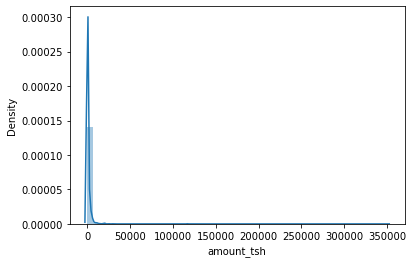

In [159]:
sns.distplot(X_train['amount_tsh'], kde=True)